/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/10
215/215 [==============================] - 152s 702ms/step - loss: 0.9695 - accuracy: 0.9328 - val_loss: 0.0074 - val_accuracy: 0.9996
Epoch 2/10
215/215 [==============================] - 150s 697ms/step - loss: 0.0104 - accuracy: 0.9994 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
215/215 [==============================] - 150s 698ms/step - loss: 4.4884e-04 - accuracy: 1.0000 - val_loss: 6.3578e-04 - val_accuracy: 1.0000
Epoch 4/10
215/215 [==============================] - 150s 699ms/step - loss: 2.2524e-04 - accuracy: 1.0000 - val_loss: 7.3922e-04 - val_accuracy: 0.9996
Epoch 5/10
215/215 [==============================] - 151s 702ms/step - loss: 1.4367e-04 - accuracy: 1.0000 - val_loss: 9.2758e-04 - val_accuracy: 0.9996
Epoch 6/10
215/215 [==============================] - 151s 701ms/step - loss: 1.0214e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9996
Epoch 7/10
215/215 [==============================] - 150s 700ms/step - loss: 7.7601e-05 - accur

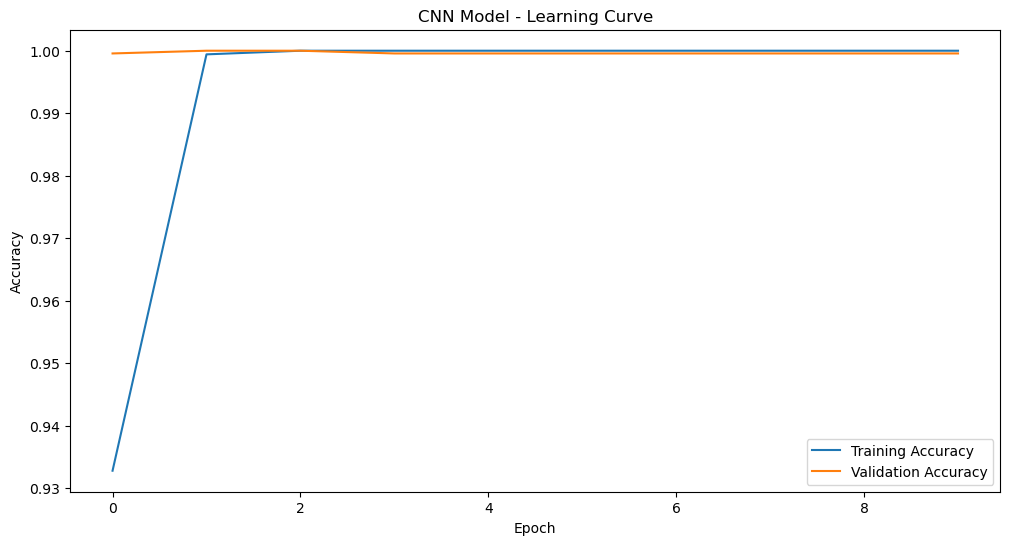

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Lambda, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load videos from a folder
def load_videos_from_folder(folder):
    videos = []
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            vid_path = os.path.join(folder, filename)
            if os.path.isfile(vid_path):
                vid = cv2.VideoCapture(vid_path)
                while True:
                    ret, frame = vid.read()
                    if not ret:
                        break
                    frame = cv2.resize(frame, (image_width, image_height))  # Resize frame to desired dimensions
                    videos.append(frame)
                vid.release()
    return videos


# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            if os.path.isfile(img_path):
                img = load_img(img_path, target_size=(image_height, image_width))
                img_array = img_to_array(img)
                images.append(img_array)
    return images


# Set the file paths for your datasets
dataset_folder = "/kaggle/input/anti-spoofing"
cut_out_printouts_folder = os.path.join(dataset_folder, "cut-out printouts")
live_selfie_folder = os.path.join(dataset_folder, "live_selfie")
live_video_folder = os.path.join(dataset_folder, "live_video")
printouts_folder = os.path.join(dataset_folder, "printouts")
replay_folder = os.path.join(dataset_folder, "replay")

# Set the desired image dimensions
image_height = 224
image_width = 224

# Load the data
cut_out_printouts = load_videos_from_folder(cut_out_printouts_folder)
live_selfie = load_images_from_folder(live_selfie_folder)
live_video = load_videos_from_folder(live_video_folder)
printouts = load_videos_from_folder(printouts_folder)
replay = load_videos_from_folder(replay_folder)

# Combine the data and labels
X = np.array(cut_out_printouts + live_selfie + live_video + printouts + replay)
y = np.array([0] * len(cut_out_printouts) + [1] * len(live_selfie) + [2] * len(live_video) + [3] * len(
    printouts) + [4] * len(replay))

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoded format
num_classes = 5
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)


# Set the desired image dimensions
image_height = 224
image_width = 224

# Build and train the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train_one_hot, batch_size=32, epochs=10, validation_data=(X_val, y_val_one_hot))

# Print the accuracy
_, train_accuracy = cnn_model.evaluate(X_train, y_train_one_hot, verbose=0)
_, val_accuracy = cnn_model.evaluate(X_val, y_val_one_hot, verbose=0)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model - Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - accuracy: 0.3333 - val_loss: 0.6964 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 103ms/step - loss: 0.6900 - accuracy: 0.6667 - val_loss: 0.7004 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 100ms/step - loss: 0.6864 - accuracy: 0.6667 - val_loss: 0.7056 - val_accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 89ms/step - loss: 0.6820 - accuracy: 0.6667 - val_loss: 0.7127 - val_accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 102ms/step - loss: 0.6765 - accuracy: 0.6667 - val_loss: 0.7232 - val_accuracy: 0.3333
Epoch 6/10
1/1 [==============================] - 0s 101ms/step - loss: 0.6696 - accuracy: 0.6667 - val_loss: 0.7398 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 0s 106ms/step - loss: 0.6606 - accuracy: 0.6667 - val_loss: 0.7700 - val_accuracy: 0.3333
Epoch 8/10
1/1 [========

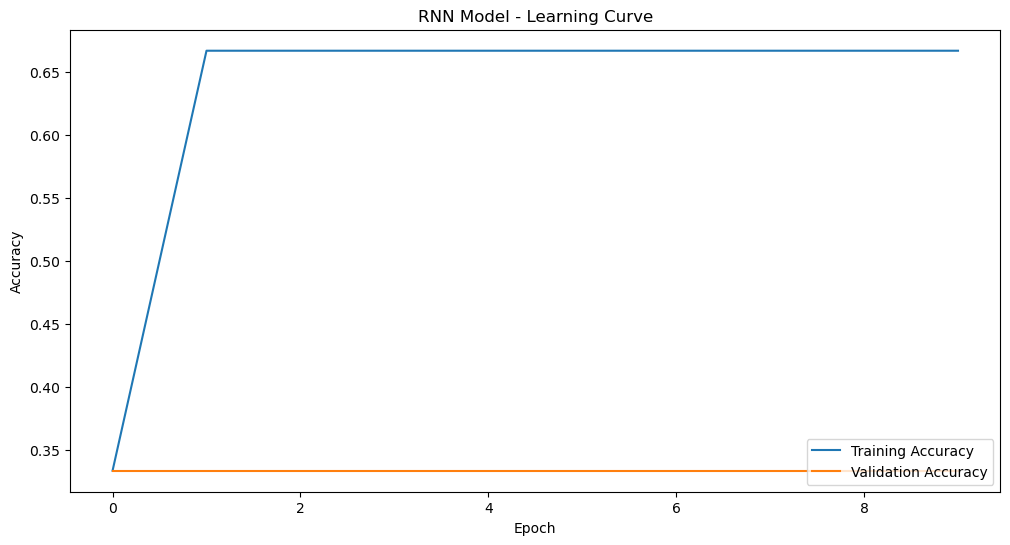

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming you have a list of sequences as your training data
X_train = [[1, 2, 3, 4], [5, 6, 7], [8, 9, 10, 11, 12]]
y_train = [0, 1, 0]  # Example labels for training data

# Assuming you have a list of sequences as your validation data
X_val = [[13, 14, 15], [16, 17], [18, 19, 20, 21, 22]]
y_val = [1, 0, 1]  # Example labels for validation data

# Pad sequences
max_frames = 100
X_train_rnn = pad_sequences(X_train, maxlen=max_frames, padding='post', truncating='post')
X_val_rnn = pad_sequences(X_val, maxlen=max_frames, padding='post', truncating='post')

# Convert labels to one-hot encoding
num_classes = 2  # Number of classes
y_train_one_hot = np.eye(num_classes)[y_train]
y_val_one_hot = np.eye(num_classes)[y_val]

# Build your RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(128, input_shape=(max_frames, 1)))  # Assuming each sequence has one feature
rnn_model.add(Dense(num_classes, activation='softmax'))

# Compile and train the RNN model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train_rnn, y_train_one_hot, validation_data=(X_val_rnn, y_val_one_hot), batch_size=32, epochs=10)

# Print the accuracy
_, train_accuracy = rnn_model.evaluate(X_train_rnn, y_train_one_hot, verbose=0)
_, val_accuracy = rnn_model.evaluate(X_val_rnn, y_val_one_hot, verbose=0)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model - Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/10
74/74 [==============================] - 318s 4s/step - loss: 0.0117 - accuracy: 0.9928 - val_loss: 2.9063e-05 - val_accuracy: 1.0000
Epoch 2/10
74/74 [==============================] - 316s 4s/step - loss: 7.3245e-07 - accuracy: 1.0000 - val_loss: 2.4841e-05 - val_accuracy: 1.0000
Epoch 3/10
74/74 [==============================] - 315s 4s/step - loss: 4.5666e-07 - accuracy: 1.0000 - val_loss: 2.2288e-05 - val_accuracy: 1.0000
Epoch 4/10
74/74 [==============================] - 315s 4s/step - loss: 2.6180e-07 - accuracy: 1.0000 - val_loss: 1.9501e-05 - val_accuracy: 1.0000
Epoch 5/10
74/74 [==============================] - 314s 4s/step - loss: 1.8791e-07 - accuracy: 1.0000 - val_loss: 1.8471e-05 - val_accuracy: 1.0000
Epoch 6/10
74/74 [==============================] - 314s 4s/step - loss: 1.3241e-07 - accuracy: 1.0000 - val_loss: 1.6725e-05 - val_accuracy: 1.0000
Epoch 7/10
74/74 [==============================] - 314s 4s/step - loss: 9.4056e-08 - accuracy: 1.0000 - val_l

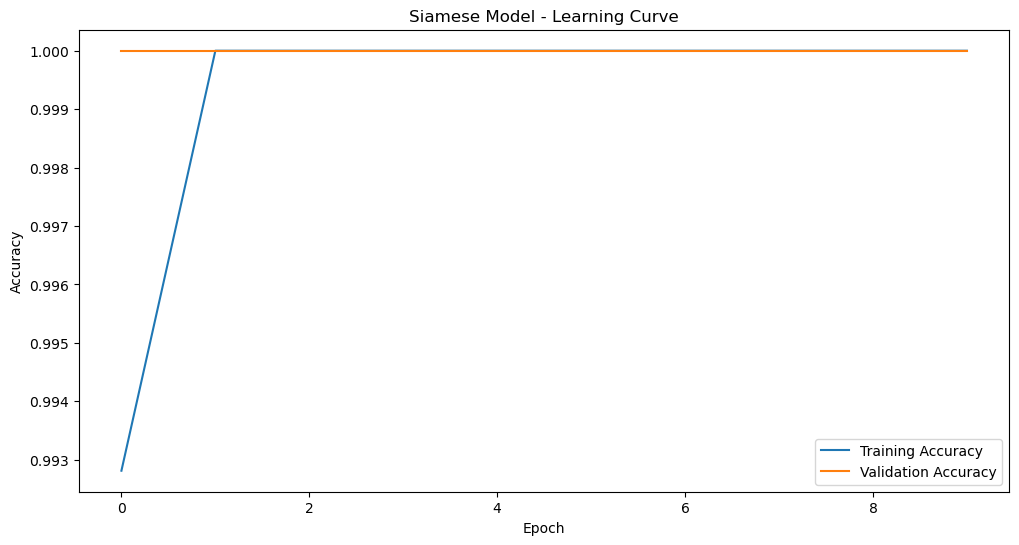

Model saved at: /kaggle/working/siamese_model.h5


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam

# Set the file paths for your datasets
dataset_folder = "/kaggle/input/anti-spoofing"
cut_out_printouts_folder = os.path.join(dataset_folder, "cut-out printouts")
live_selfie_folder = os.path.join(dataset_folder, "live_selfie")
live_video_folder = os.path.join(dataset_folder, "live_video")
printouts_folder = os.path.join(dataset_folder, "printouts")
replay_folder = os.path.join(dataset_folder, "replay")

# Load the dataset
def load_dataset():
    X_train_left = []
    X_train_right = []
    y_train = []
    
    # Load cut-out printouts
    for file in os.listdir(cut_out_printouts_folder):
        if file.endswith(".jpg"):
            image_path = os.path.join(cut_out_printouts_folder, file)
            image = cv2.imread(image_path)
            if image is not None:
                X_train_left.append(image)
                X_train_right.append(image)
                y_train.append(0)  # Spoof label

    # Load live selfie
    for file in os.listdir(live_selfie_folder):
        if file.endswith(".mov") or file.endswith(".mp4"):
            video_path = os.path.join(live_selfie_folder, file)
            # Read and process video frames
            frames = process_video(video_path)
            if len(frames) > 1:
                for i in range(len(frames) - 1):
                    X_train_left.append(frames[i])
                    X_train_right.append(frames[i + 1])
                    y_train.append(1)  # Genuine label

    # Load live video
    for file in os.listdir(live_video_folder):
        if file.endswith(".mov") or file.endswith(".mp4"):
            video_path = os.path.join(live_video_folder, file)
            # Read and process video frames
            frames = process_video(video_path)
            if len(frames) > 1:
                for i in range(len(frames) - 1):
                    X_train_left.append(frames[i])
                    X_train_right.append(frames[i + 1])
                    y_train.append(1)  # Genuine label

    X_train_left = np.array(X_train_left)
    X_train_right = np.array(X_train_right)
    y_train = to_categorical(y_train)

    # Split the data into training and validation sets
    X_train_left, X_val_left, X_train_right, X_val_right, y_train, y_val = train_test_split(
        X_train_left, X_train_right, y_train, test_size=0.2, random_state=42
    )

    return X_train_left, X_train_right, y_train, X_val_left, X_val_right, y_val

# Process video frames
def process_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (image_width, image_height))
        frames.append(frame)
    cap.release()
    return frames

# Set the desired image dimensions
image_height = 224
image_width = 224


# Define the Siamese model
def build_siamese_model(input_shape):
    # Define the input tensors
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Define the shared convolutional neural network
    cnn = build_cnn(input_shape)

    # Generate the encodings for the left and right inputs
    encoded_left = cnn(left_input)
    encoded_right = cnn(right_input)

    # Compute the absolute difference between the encodings
    L1_distance = Lambda(lambda x: abs(x[0] - x[1]))([encoded_left, encoded_right])

    # Add a dense layer with softmax activation to obtain the similarity scores
    prediction = Dense(2, activation='softmax')(L1_distance)

    # Connect the inputs and outputs to create the Siamese model
    siamese_model = Model(inputs=[left_input, right_input], outputs=prediction)

    # Compile the model with categorical cross-entropy loss and Adam optimizer
    siamese_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

    return siamese_model

# Build the CNN for feature extraction
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    return model

# Load the dataset
X_train_left, X_train_right, y_train, X_val_left, X_val_right, y_val = load_dataset()

# Build the Siamese model
siamese_model = build_siamese_model(input_shape=(image_height, image_width, 3))

# Train the Siamese model
siamese_history = siamese_model.fit(
    [X_train_left, X_train_right], y_train,
    validation_data=([X_val_left, X_val_right], y_val),
    batch_size=32, epochs=10
)

# Get the accuracy of the Siamese model
siamese_accuracy = siamese_history.history['val_accuracy'][-1]


# Print the accuracy
_, train_accuracy = siamese_model.evaluate([X_train_left, X_train_right], y_train, verbose=0)
_, val_accuracy = siamese_model.evaluate([X_val_left, X_val_right], y_val, verbose=0)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(siamese_history.history['accuracy'], label='Training Accuracy')
plt.plot(siamese_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Siamese Model - Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the trained model
model_path = "/kaggle/working/siamese_model.h5"  # Specify the path where you want to save the model
siamese_model.save(model_path)
print("Model saved at:", model_path)


In [43]:
import os
import cv2
import numpy as np
from keras.models import load_model

def load_and_preprocess_video(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print("Error: File not found:", file_path)
        return None

    # Load the video using OpenCV
    cap = cv2.VideoCapture(file_path)

    # Check if the video was loaded successfully
    if not cap.isOpened():
        print("Error loading video:", file_path)
        return None

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error reading frame from video:", file_path)
        cap.release()
        return None

    # Preprocess the frame
    frame = cv2.resize(frame, (224, 224))
    frame = frame / 255.0  # Normalize pixel values to the range [0, 1]
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension

    cap.release()
    return frame

def predict_class(frame1, frame2):
    # Load the trained model
    model_path = "/kaggle/working/siamese_model.h5"
    model = load_model(model_path)

    # Predict the class
    pred = model.predict([frame1, frame2])
    pred_class = np.argmax(pred)

    # Get the predicted class label
    if pred_class == 0:
        return "Genuine"
    else:
        return "Spoof"

# Define the folder paths and file extensions for the datasets
datasets = {
    "Dataset 1": {
        "folder_path": "/kaggle/input/anti-spoofing/cut-out printouts",
        "file_extensions": (".mp4",)
    },
    "Dataset 2": {
        "folder_path": "/kaggle/input/anti-spoofing/live_selfie",
        "file_extensions": (".jpg",)
    },
    "Dataset 3": {
        "folder_path": "/kaggle/input/anti-spoofing/live_video",
        "file_extensions": (".mp4",)
    },
    "Dataset 4": {
        "folder_path": "/kaggle/input/anti-spoofing/printouts",
        "file_extensions": (".mp4",)
    },
    "Dataset 5": {
        "folder_path": "/kaggle/input/anti-spoofing/replay",
        "file_extensions": (".mp4",)
    }
}

# Iterate over the datasets and files to predict the classes
for dataset_name, dataset_info in datasets.items():
    print("Dataset:", dataset_name)
    folder_path = dataset_info["folder_path"]
    file_extensions = dataset_info["file_extensions"]

    # Iterate over the files in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # Check if the file has the desired extension
        if any(file_name.lower().endswith(ext) for ext in file_extensions):
            # Load and preprocess the video frames
            frame1 = load_and_preprocess_video(file_path)
            frame2 = load_and_preprocess_video(file_path)  # Use the same video as both frames for testing
            if frame1 is not None and frame2 is not None:
                predicted_label = predict_class(frame1, frame2)
                print("Video:", file_name, "Predicted class:", predicted_label)
            else:
                print("Error loading video:", file_name)


Dataset: Dataset 1
1/1 [==============================] - 0s 177ms/step
Video: 0001e96803--6239bb2420237d576aade0ea.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 175ms/step
Video: 0001e96803--62294efac72a824e5bb369f3.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 171ms/step
Video: 0001e96803--624508e961974a65884d9fd3.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 171ms/step
Video: 0001e96803--623955e76e1ee5175569a12b.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 204ms/step
Video: 0001e96803--62663cf6d21d14509973bcb4.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 181ms/step
Video: 0001e96803--625473b64949293a58c89e41.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 175ms/step
Video: 0001e96803--62457bc94ff454214e8af551.mp4 Predicted class: Spoof
1/1 [==============================] - 0s 172ms/step
Video: 0001e96803--6228928cb608822f9f53589e.mp4 Predicted cl